In [1]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D

from astropy import units as u
from astropy import constants as const
import glob
#import yt
#from yt.units import kpc
#import ytree
from matplotlib.patches import Rectangle
import pandas as pd
import time
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.interpolate import griddata
from scipy import interpolate
CMAP = cm.coolwarm
import hmf
from hmf import MassFunction
from scipy import special
from scipy import interpolate


import random
from scipy.stats import poisson
import astropy
from astropy import units as u
import io

# Setting up the HMF which will determine the final mass of our trees at z=5

In [3]:
#J1 from https://arxiv.org/pdf/1806.07893.pdf. I'm not sure if it's safe to say M_peak = M_halo
#valid for M_halo 10^10 - 10^15 M_sol and z 0-10
#1/30/2022, updating the values for the row: TRUE, SF, ALL, EXCL

E0 = -1.494
Ea = 1.569
Elna = 1.293
Ez = -0.215
M0 = 12.059
Ma = 4.645
Mlna = 4.544
Mz = -0.757
A0 = 1.905
Aa = -2.555
Alna = -1.875
Az = 0.197
B0 = 0.509
Ba = -0.889
Bz = -0.538
D0 = 0.460
Y0 = -0.807
Ya = -1.859
Yz = -0.637
Msol = 1.989e30

def a(z0):
    return 1/(1+z0)

def log10_m_2(z0):
    return M0 + Ma*(a(z0)-1) - Mlna*np.log(a(z0)) + Mz*z0 #+math.log10(Msol)

def epsilon2(z0):
    return E0 + Ea*(a(z0)-1) - Elna*np.log(a(z0)) + Ez*z0

def alpha2(z0):
    return A0 + Aa*(a(z0)-1) - Alna*np.log(a(z0)) + Az*z0

def beta2(z0):
    return B0 + Ba*(a(z0)-1) + Bz*z0

def delta2(z0):
    return D0

def gamma2(z0):
    return 10**(Y0 + Ya*(a(z0)-1) + Yz*z0) 


def get_peak(mass):
    peak = 0
    for x in range(len(mass)):
        if(mass[x] < peak): mass[x] = peak
        else: peak = mass[x]
    return mass


#Behroozi 2019, the version we're going with
def calc_mass_beh_2019(m_h, z):
    m_h = get_peak(np.array(m_h))
    z   = np.array(z)
    x = np.log10(m_h) - log10_m_2(z)
    a = -np.log10(np.float_power(10, -alpha2(z)*x) + np.float_power(10,-beta2(z)*x))
    b = gamma2(z)*np.exp(-0.5*np.float_power(x,2)/(delta2(z)**2))
    log10_m_s = epsilon2(z) + log10_m_2(z) + a + b
    sm = np.float_power(10, log10_m_s)
    min_mass = 100
    sm[np.where(sm < min_mass)]= min_mass
    return sm

def calc_mass_wise(z,m_h):
    z=np.array(z)
    m_h = np.log10(m_h)
    
    mh_filter = np.where((m_h<=8.5))
    m_h = m_h[mh_filter]

    m_vir_power = np.arange(6.5,8.6, 0.5)
    m_star_power = [3.41, 3.59,3.88,4.60,5.74]
    f =interpolate.interp1d(m_vir_power, m_star_power, kind='linear',fill_value='extrapolate')
    m_star = f(m_h)
    return z[mh_filter], np.power(10, m_h), np.power(10, m_star)

def calc_mass(m_h,z):
    fraction =0.005
    try:
        behroozi_mass_index_first = np.where((m_h >= 10**10.5) &(z<=10))[0][0]
        end=behroozi_mass_index_first
    except:
        end=len(m_h)-1

    z_wise, m_halo, m_star = calc_mass_wise(z,m_h)
    stellar_mass = np.zeros(len(m_h))
    beh_mass = calc_mass_beh_2019(m_h[end:],z[end:])
#     print(beh_mass)

    
    m0 = m_star[-1]
    mf = beh_mass[0]

    start=-1
    for x in range(len(m_star)):
        stellar_mass[x] = m_star[x]
        start+=1
    slope = (mf-m0)/(m_h[end] - m_h[start])
    for x in range(start,end,1):
        stellar_mass[x] = (m_h[x]-m_h[start])*slope + m0
    for x in range(end,len(m_h)):
        stellar_mass[x] = beh_mass[x-end]
    

    return stellar_mass


In [4]:
m_h = np.logspace(7,12.5, 400)
z = np.linspace(5,5, len(m_h))
m_star = calc_mass(m_h, z)
log_m_star = np.log10(m_star)
low, up =  7.8, 10.2

args = np.where((log_m_star >= low) & (log_m_star <= up))
low_mh, up_mh = np.min(m_h[args]), np.max(m_h[args])
print(np.log10(low_mh), np.log10(up_mh))

In [43]:
low_mh, up_mh = np.min(m_h[args]), np.max(m_h[args])
print(np.log10(low_mh), np.log10(up_mh))

10.639097744360903 12.072681704260651


['ERROR_ON_BAD_MDEF', '_dlnsdlnm', '_growth_factor_fn', '_gtm', '_normalisation', '_power0', '_sigma_0', '_unn_sig8', '_unn_sigma0', '_unnormalised_lnT', '_unnormalised_power', 'cosmo', 'delta_k', 'dndlnm', 'dndlog10m', 'dndm', 'filter', 'fsigma', 'growth', 'growth_factor', 'halo_overdensity_crit', 'halo_overdensity_mean', 'hmf', 'how_big', 'k', 'lnsigma', 'm', 'mass_nonlinear', 'mdef', 'mean_density', 'mean_density0', 'n_eff', 'ngtm', 'nonlinear_delta_k', 'nonlinear_power', 'normalised_filter', 'nu', 'power', 'radii', 'rho_gtm', 'rho_ltm', 'sigma', 'transfer', 'transfer_function']


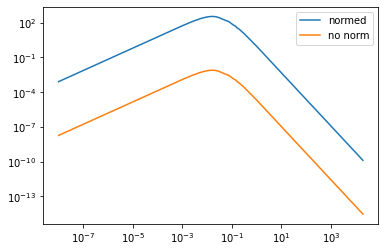

In [29]:
mf = MassFunction()
print(mf.quantities_available())
mf.z=10
# plt.plot(mf.k, mf._power0*np.power(D(10)/D(0),2), label="p0")
plt.plot(mf.k, mf.power, label="normed")
#plt.plot(mf.k, mf.nonlinear_power)
plt.plot(mf.k, mf._unnormalised_power, label="no norm")
plt.legend()
plt.yscale("log")
plt.xscale("log")

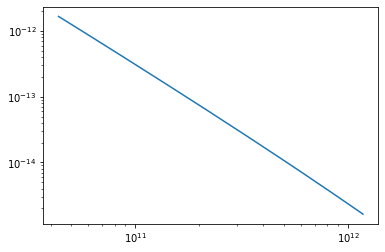

In [45]:

dndm = mf.dndm
m = mf.m
args_hm = np.where((m>= low_mh) & (m <= up_mh))

plt.plot(m[args_hm], dndm[args_hm])
m_filt = m[args_hm]
dndm_filt = dndm[args_hm]
plt.yscale("log")
plt.xscale("log")

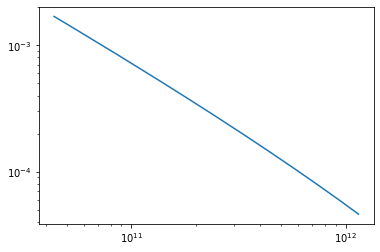

In [51]:

dms = m_filt[1:] - m_filt[:-1]
dn = dndm_filt[:-1]*dms
plt.plot(m_filt[:-1], dn)
plt.yscale("log")
plt.xscale("log")

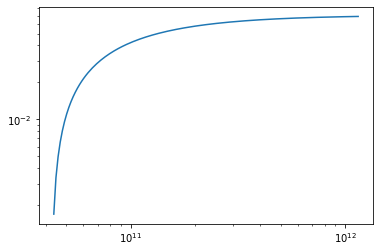

In [52]:

cumsum = np.cumsum(dn)
plt.plot(m_filt[:-1], cumsum)
plt.yscale("log")
plt.xscale("log")


In [119]:

N_trees = int(1e4)
print(N_trees)
rans = np.random.uniform(low=np.min(cumsum), high=np.max(cumsum),size=N_trees)
print(rans)

10000
[0.02712526 0.01816824 0.04958598 ... 0.00389007 0.03600153 0.02842166]


In [120]:

m_h_target =interpolate.interp1d(cumsum, m_filt[:-1], kind='cubic',fill_value='extrapolate')(rans)

array([6.73546301e+10, 5.65167077e+10, 1.31356285e+11, ...,
       4.50176082e+10, 8.32667523e+10, 6.92829599e+10])

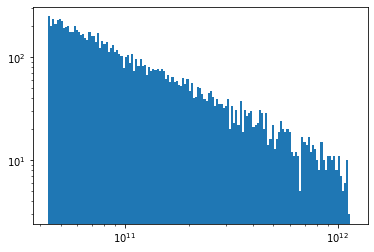

In [122]:
plt.hist(m_h_target, bins=m_filt)
plt.yscale("log")
plt.xscale("log")

# Now with the target halo masses, send this to the catalog.txt file(s) for the MC tree code

In [123]:
print(np.max(m_h_target)/1e12)
print(np.min(m_h_target)/1e10)


1.1447265371849404
4.365189214538868


In [ ]:
N_per_file = 250
working_dir = "trees_for_j"
N_files = int(N_trees/N_per_file)
catalog_base = "catalog_base.txt"
for x in range(N_files):
    number = str(x)
    with io.open(working_dir+"/"+catalog_base, "r", newline='\n') as fin:
        with io.open(working_dir+"/catalog"+number+".txt", "w", newline='\n') as fout:
            for line in fin:
                if("mass" not in line):
                    fout.write((line.replace('N', number)).replace('\r', ''))
            #print(list(fout))
            mhs = m_h_target[x*N_per_file:(x+1)*N_per_file]
            for i in range(len(mhs)):
                newline = "{:e}".format(mhs[i])+"   0  " + number + "\n"
                fout.write(newline.replace('\r', ''))
    fin.close()
    fout.close()
    
    with io.open(working_dir+"/skx_base", "r", newline='\n') as fin:
        with io.open(working_dir+"/skx"+number, "w", newline='\n') as fout:
            for line in fin:
                fout.write((line.replace('NUMBER', number)).replace('\r', ''))

    with io.open(working_dir+"/skx_find_base", "r", newline='\n') as fin:
        with io.open(working_dir+"/skx_find"+number, "w", newline='\n') as fout:
            for line in fin:
                fout.write((line.replace('NUMBER', number)).replace('\r', ''))




    fin.close()
    fout.close()
    
with io.open(working_dir+"/submit_jobs_find.sh", "w", newline='\n') as fout:
    fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
    for x in range(N_files):
        
        fout.write(("sbatch skx_find"+str(x)+"\n\n").replace('\r', ''))
    fout.close()

with io.open(working_dir+"/submit_jobs.sh", "w", newline='\n') as fout:
    fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
    for x in range(N_files):
        
        fout.write(("sbatch skx"+str(x)+"\n\n").replace('\r', ''))
    fout.close()

with io.open(working_dir+"/submit_jobs.sh", "w", newline='\n') as fout:
    fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
    for x in range(N_files):
        
        fout.write(("sbatch skx"+str(x)+"\n\n").replace('\r', ''))
    fout.close()

# Grow the trees

In [3]:

def evolve_BH(halo_mass, time, folding_time, fraction_cap, seed, cap_fraction = 1):  
    dt = np.array(time[1:len(time)])-np.array(time[0:len(time)-1])
    scale_factor = np.exp(dt/folding_time)
    cap =fraction_cap*np.array(halo_mass*OMEGA_B/OMEGA_M)

    if(seed == -1): bh_mass = [cap[0]*cap_fraction]
    else: bh_mass = [seed]

    for i,sf in enumerate(scale_factor):
        old_mass = bh_mass[i]
        growth = old_mass*sf
        c = cap[i+1]

        if(growth <= c): 
            bh_mass.append(growth)
        elif(c>old_mass):
            bh_mass.append(c)
        else: 
            bh_mass.append(old_mass) #this occurs when the cap shrinks due to stripping
            
    return bh_mass

def create_tree_df(tree):
    names = ["z", "time", "mass", "t_vir", "stellar_mass", "j_mean", "j_ratio", "j_lw", "ind", "desc"]
    z,m = tree[0], tree[1]
    jmean, jr, jlw = tree[2], tree[3], tree[4]
    ind, desc = tree[5], tree[6]
    t_vir = T_vir(m,z)
    time = z_to_time(z)
    sm = calc_mass(m,z)    
#         sm = sm1#np.maximum(sm1,sm2)

    data = np.array([z,time,m,t_vir,sm,jmean, jr, jlw, ind, desc]).T
    data = np.array(data)
    df = pd.DataFrame(data,columns = names)
    
    
    
    return df


In [4]:
OMEGA_B = 0.0486 
OMEGA_M = 0.307
OMEGA_L = 1-OMEGA_M
SIGMA_8 = 0.81
delta_c = 1.686
h=0.677
rho_crit = 1.5*1e11 #Msol/mpc^3
T_HUBBLE = 4.55e17 #s
MPC_TO_CM = 3.086e+24

K = 1.380649e-16 #ergs/K
SEC_PER_MYR = 3.15576e+13
m_p = 1.6e-27
msol = 2e30
mpc = 3.086e+24
n = rho_crit*msol/mpc**3*OMEGA_B/m_p #cm^-3



u=1.22
N_GAS=0.2



def T_vir(m,z):
    h=0.7 
    
    u = 1.22
    #eq 26 from https://arxiv.org/pdf/astro-ph/0010468.pdf
    #returns virial temp in units of Kelvin
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1

    delta_c = 18*np.pi*np.pi + 82*d -39*d*d
    return 1.98e4*(u/0.6)*np.float_power(m*h/1e8, 2.0/3)*np.float_power(OMEGA_M/OMEGA_M_Z * delta_c/(18*np.pi*np.pi),1.0/3) *(1+z)/10.0


def T_vir_inverted(T,z):
    h=0.7
    u = 1.22
    #eq 26 from https://arxiv.org/pdf/astro-ph/0010468.pdf
    #returns virial temp in units of Kelvin
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1

    delta_c = 18*np.pi*np.pi + 82*d -39*d*d
    m = np.float_power(T/(1.98e4*(u/0.6)) / (np.float_power(OMEGA_M/OMEGA_M_Z * delta_c/(18*np.pi*np.pi),1.0/3) *(1+z)/10.0),3.0/2)*1e8/h
    return m


def z_to_time(z):
        a=2./(3.*np.sqrt(OMEGA_L))
        b = np.sqrt(OMEGA_L/OMEGA_M)*np.float_power(1+z, -1.5)
        c = 71*1e5*3.154e+7/3.086e18
        return a/c*np.log(b+np.sqrt(1+b*b))


def get_tree_num(f):
    return int(str(f.split("tree_")[-1]).split("_")[0])

def get_chunk_num(f):
    return int((f.split("chunk_")[-1]).split("_in")[0])

def get_all_branches():
    
    all_cand_files = np.sort(glob.glob("dcbh_files/*.csv"))
#     print(all_cand_files[0])
    tree_nums = [get_tree_num(f) for f in all_cand_files]

#     tree_nums = [int(str(f.split("tree")[-1]).split("\\")[0]) for f in all_cand_files]
    chunk_nums = [get_chunk_num(f) for f in all_cand_files]
    ids = [250*tn + cn for tn,cn in zip(tree_nums, chunk_nums)]
    all_cand_files = all_cand_files[np.argsort(ids)]
    all_trees_raw = []
    num_dcbhs = []

    all_trees = []
    tree_ids = []
    tree_num = -1
    for f in all_cand_files:



#         current_num = int(str(f.split("tree")[-1]).split("\\")[0])
        current_num = get_tree_num(f)
        chunk_num = get_chunk_num(f)
        if(current_num != tree_num):
            tree_num = current_num
            print("working on tree", tree_num)

        ds =  pd.read_csv(f)
        if(len(ds) == 0): continue
        desc = np.array(ds["desc"])
        inds = np.array(ds["ind"])
        mass = np.array(ds["mass/1e10"])*1e10
        z = get_redshift("Snapshot_alist_mod")
        snaps = np.array(ds["snap_num"])
        mean_jlw = np.array(ds["mean_jlw"])
        j_ratios = np.array(ds["j_ratios"])
        j_lw = np.array(ds["j_lw"])
        zs = np.array(z)[snaps]

        all_trees_raw.append(np.array([zs, z_to_time(zs), mass,inds, desc]))


        dcbh_starts = np.setdiff1d(inds, desc)
        num_dcbhs.append(len(dcbh_starts))

        index = [np.where(inds == start)[0][0] for start in dcbh_starts]
        max_ir = np.argsort(j_lw[index])[-BRANCH_PER_TREE:]
        dcbh_starts = (inds[index])[max_ir]

        all_branches = []
        for start in dcbh_starts:
            index = np.where(inds == start)[0]
            if(len(index)>1):print("ERROR")
            index = index[0]
            #print(index)
            mass_list, z_list = [],[]
            ind_values, desc_values = [],[]
            jmean, jr,jlw = [],[],[]
            desc_id = np.where(inds == desc[index])[0][0]
            count = 0
            while(True):
                mass_list.append(mass[index])
                z_list.append(zs[index])
                jmean.append(mean_jlw[index])
                jr.append(j_ratios[index])
                jlw.append(j_lw[index])
                ind_values.append(inds[index])
                desc_values.append(desc[index])
                #if(count ==0): print(mass_list[0], z_list[0])
                index = desc_id
                desc_id = np.where(inds == desc[index])[0]
                if(len(desc_id) == 0): 
                    z_list.append(zs[0])
                    mass_list.append(mass[0])
                    jmean.append(mean_jlw[0])
                    jr.append(j_ratios[0])
                    jlw.append(j_lw[0])
                    ind_values.append(inds[0])
                    desc_values.append(desc[0])
                    break
                if(len(desc_id) > 1): print("ERROR")
                desc_id = desc_id[0] 
                count+=1
            all_branches.append(np.array([np.array(z_list), np.array(mass_list), 
                                          np.array(jmean), np.array(jr), np.array(jlw), 
                                          ind_values, desc_values]))
            tree_ids.append(100*int(tree_num)+int(chunk_num))
        for t in all_branches: all_trees.append(create_tree_df(t))
    tree_ids = np.array(tree_ids)
    return tree_ids, all_trees

def get_all_trees(tree_ids, all_branches,ft,cap,optimstic,keep_all,full=True,seed=-1, cap_fraction=1.0):
    
    all_trees = []
    for tree_id in np.sort(np.unique(tree_ids)):
        #if(tree_id!=94):continue
        branches = [all_branches[i] for i in np.sort(np.where(tree_ids == tree_id)[0])]

        if(not optimstic):
            all_init_j_lw = [branch["j_lw"][0] for branch in branches]
            tree = branches[np.argmax(all_init_j_lw)]
            tree = tree.drop(['j_mean',	'j_ratio',	'ind',	'desc'], axis=1)
            tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed, cap_fraction = cap_fraction)
            all_trees.append(tree)
 
        else:
            all_z, all_inds, all_bh, all_m, all_sm, all_bh,all_t, all_jlw= [],[],[],[],[],[],[],[]


            for branch in branches:
                all_z.append(np.array(branch["z"]))
                all_t.append(z_to_time(np.array(branch["z"])))
                all_inds.append(np.array(branch["ind"]))
                all_sm.append(np.array(branch["stellar_mass"]))
                all_m.append(np.array(branch["mass"]))
                all_jlw.append(np.array(branch["j_lw"]))
                all_bh.append(np.zeros(len(np.array(branch["mass"]))))


            
            m_all_z, m_all_inds, m_all_bh, m_all_m, m_all_sm,m_all_t, m_all_jlw= [],[],[],[],[],[],[]
            total_steps_index = np.argmax([len(zlist) for zlist in all_z])
            total_z = all_z[total_steps_index]
            total_steps = len(total_z)
            for step in range(total_steps):

                indices_for_branch = []
                z_step = total_z[step]

                for z_list in all_z:
                    if(z_step in z_list): indices_for_branch.append(np.where(z_list ==z_step)[0][0])
                    else: indices_for_branch.append(-1)

                current_inds = []
                #print(z_step, indices_for_branch)
                for x in range(len(indices_for_branch)):
                    branch_index = indices_for_branch[x]
                    if(branch_index == -1): 
                        if(-1 not in current_inds): current_inds.append(-1)
                        else: current_inds.append(min(current_inds) - 1)
                        continue
                    else:
                        #seeding or growing BHs
                        if(branch_index == 0): 
                            if(seed==-1):all_bh[x][0] = (cap*OMEGA_B/OMEGA_M)*all_m[x][0]
                            else: all_bh[x][0] = seed
                        else: 
                            i2,i1 = branch_index, branch_index-1
                            m,t = all_m[x][i1:i2+1],all_t[x][i1:i2+1]
                            all_bh[x][i2] = evolve_BH(m, t, ft, cap, all_bh[x][i1], cap_fraction = cap_fraction)[-1]              
         
                        current_inds.append(all_inds[x][branch_index])
                
                if(len(current_inds) != len(np.unique(current_inds))):
                    #print("current inds:", current_inds)
                    unq, unq_idx, unq_cnt = np.unique(current_inds, return_inverse=True, return_counts=True)
                    merger_indx = np.where(unq[np.argmax(unq_cnt)] == np.array(current_inds))[0]

                    indx_list = []
                    i1,i2 = merger_indx[0],merger_indx[1]
                    bh_list = [all_bh[i][indices_for_branch[i]] for i in merger_indx]
                    z_init_list = [all_z[i][0] for i in merger_indx]
                    j_init_list = [all_jlw[i][0] for i in merger_indx]
                    #print("bh_list=",bh_list)
                    total_mass = np.max(bh_list)
                    #keep = merger_indx[np.argmax(bh_list)]
                    keep = merger_indx[np.argmax(z_init_list)]
                    #for i in merger_indx: all_bh[i][indices_for_branch[i]] = 0
                    all_bh[keep][indices_for_branch[keep]] = total_mass
                    
                    #translate from merger index to global index
                    
                    for i in np.sort(merger_indx)[::-1]:
                        if(i==keep): continue
                        #print(i)
                        if(full):
                            m_all_z.append(all_z[i])    
                            m_all_inds.append(all_inds[i])    
                            m_all_m.append(all_m[i])    
                            m_all_sm.append(all_sm[i])    
                            m_all_t.append(all_t[i])    
                            m_all_bh.append(all_bh[i])    
                            m_all_jlw.append(all_jlw[i])    
                        else: 
                            m_all_z.append(all_z[i][:indices_for_branch[i]+1])    
                            m_all_inds.append(all_inds[i][:indices_for_branch[i]+1])    
                            m_all_m.append(all_m[i][:indices_for_branch[i]+1])    
                            m_all_sm.append(all_sm[i][:indices_for_branch[i]+1])    
                            m_all_t.append(all_t[i][:indices_for_branch[i]+1])    
                            m_all_bh.append(all_bh[i][:indices_for_branch[i]+1])
                            m_all_jlw.append(all_jlw[i][:indices_for_branch[i]+1])
                        del all_z[i]
                        del all_t[i]
                        del all_inds[i]
                        del all_sm[i]
                        del all_m[i]
                        del all_jlw[i]
                        del all_bh[i]
            if(full): 
                all_indices = list(all_inds[0])
                all_bh_masses_for_indices = list(all_bh[0])
                for x in range(len(m_all_bh)):
                    pre_merger_indices = np.where(m_all_bh[x] != 0)[0]
                    all_indices.extend(np.array(m_all_inds[x])[pre_merger_indices])
                    all_bh_masses_for_indices.extend(np.array(m_all_bh[x])[pre_merger_indices])

                for x in range(len(m_all_bh)):
                    post_merger_indices = np.where(m_all_bh[x] == 0)[0]
                    for y in post_merger_indices:
                        ind = m_all_inds[x][y]
                        if(ind in all_indices):
                            merged_mass = all_bh_masses_for_indices[np.where(np.array(all_indices) == ind)[0][0]]
                            m_all_bh[x][y] = merged_mass
                        else: print("ERROR", tree_id,x)
                    
                
 
            
            
            names = ["z", "time", "mass", "t_vir", "stellar_mass", "bh_mass","inds", "j_lw"]
            z,time,m = all_z[0],all_t[0], all_m[0]
            t_vir = T_vir(m,z)
            sm = all_sm[0]
            bhm = all_bh[0]
            inds = all_inds[0]
            jlw = all_jlw[0]
            data = np.array([z,time,m,t_vir,sm,bhm,inds, jlw]).T
            data = np.array(data)
            df = pd.DataFrame(data,columns = names)
            all_trees.append(df)
            if(keep_all):
                for x in range(len(m_all_m)):
                    z,time,m = m_all_z[x],m_all_t[x], m_all_m[x]
                    t_vir = T_vir(m,z)
                    sm = m_all_sm[x]
                    bhm = m_all_bh[x]
                    inds = m_all_inds[x]
                    jlw = m_all_jlw[x]
                    data = np.array([z,time,m,t_vir,sm,bhm,inds, jlw]).T
                    data = np.array(data)
                    df = pd.DataFrame(data,columns = names)
                    all_trees.append(df)    


            
            

    
    return all_trees



def get_redshift(file):
    f = open(file, "r")
    z=[]
    for line in f:
        a=float(line.strip("\n"))
        z.append(1/a - 1)
    return z

def create_tree_df_simple(tree):
    names = ["z", "time", "mass", "t_vir", "stellar_mass"]
    z,m = tree[0], tree[1]
    t_vir = T_vir(m,z)
    time = z_to_time(z)
    sm = calc_mass(m,z)    
    data = np.array([z,time,m,t_vir,sm]).T
    data = np.array(data)
    df = pd.DataFrame(data,columns = names)
    
    return df


def read_filtered_trees(ft, cap,seed):
    all_tree_files = glob.glob("filtered_trees/*")
    all_trees=[]
    for f in all_tree_files: 
        tree = pd.read_csv(f)
        tree = tree[tree["z"] < 25]
        tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
        all_trees.append(tree)
        
        
    return all_trees
def find_averages(all_trees,median=False):
    
    all_bh_mass = np.array([list(t["bh_mass"]) for t in all_trees])
    all_sm = np.array([list(t["stellar_mass"]) for t in all_trees])
    lengths = np.array([np.size(b) for b in all_bh_mass])
    bh_avs, bh_std = [], []
    sm_avs, sm_std = [], []
    for x in range(np.max(lengths)):
        filter_ = np.where(x<lengths)[0]
        bh_temp = all_bh_mass[filter_]
        sm_temp = all_sm[filter_]
        bhs = [bh_temp_it[x] for bh_temp_it in bh_temp]
        if(median): bh_avs.append(np.median(bhs))
        else: bh_avs.append(np.mean(bhs))
        bh_std.append(np.std(bhs))
        sms = [sm_temp_it[x] for sm_temp_it in sm_temp]
        if(median): sm_avs.append(np.median(sms))
        else: sm_avs.append(np.mean(sms))
        sm_std.append(np.std(sms))
    bh_avs,bh_std, sm_avs, sm_std = np.array(bh_avs), np.array(bh_std), np.array(sm_avs), np.array(sm_std)
    z_av,time_av = np.array(all_trees[np.argmax(lengths)]["z"]), np.array(all_trees[np.argmax(lengths)]["time"])
    return z_av,bh_avs,bh_std, sm_avs, sm_std


def find_min_max_bh(all_trees):
    final_bh_mass = np.array([list(t["bh_mass"])[-1] for t in all_trees])
    smallest_arg, largest_arg = np.argmin(final_bh_mass), np.argmax(final_bh_mass)

    least_massive_sm = np.array(all_trees[smallest_arg]["stellar_mass"])
    least_massive_bh = np.array(all_trees[smallest_arg]["bh_mass"])
    most_massive_sm  = np.array(all_trees[largest_arg]["stellar_mass"])
    most_massive_bh  = np.array(all_trees[largest_arg]["bh_mass"])
    return least_massive_sm, least_massive_bh, most_massive_sm, most_massive_bh

In [49]:
all_tree_files = glob.glob("trees/*")
print(all_tree_files)
f=all_tree_files[0]
ds =  pd.read_csv(f,delim_whitespace=True,skiprows=1,names=["ind","snap_num","desc","prog_count","first_prog","next_prog","mass/1e10"])

['trees\\batch_0', 'trees\\batch_1', 'trees\\batch_10', 'trees\\batch_11', 'trees\\batch_12', 'trees\\batch_13', 'trees\\batch_14', 'trees\\batch_15', 'trees\\batch_16', 'trees\\batch_17', 'trees\\batch_18', 'trees\\batch_19', 'trees\\batch_2', 'trees\\batch_20', 'trees\\batch_21', 'trees\\batch_22', 'trees\\batch_23', 'trees\\batch_24', 'trees\\batch_25', 'trees\\batch_26', 'trees\\batch_27', 'trees\\batch_28', 'trees\\batch_29', 'trees\\batch_3', 'trees\\batch_30', 'trees\\batch_31', 'trees\\batch_32', 'trees\\batch_33', 'trees\\batch_34', 'trees\\batch_35', 'trees\\batch_36', 'trees\\batch_37', 'trees\\batch_38', 'trees\\batch_39', 'trees\\batch_4', 'trees\\batch_5', 'trees\\batch_6', 'trees\\batch_7', 'trees\\batch_8', 'trees\\batch_9']


# randomly select a branch from each tree which will host our light seed 

In [5]:
# total_files = 40
# trees_per_file = 250

# all_tree_files = glob.glob("trees/*")
# all_trees = []



# for tree_num in range(total_files):
#     print("starting tree ", tree_num)
#     print(all_tree_files[tree_num])
#     ds =  pd.read_csv(all_tree_files[tree_num],delim_whitespace=True,skiprows=1,names=["ind","snap_num","desc","prog_count","first_prog","next_prog","mass/1e10"])
    
#     inds = np.array(ds["ind"])
#     ends = np.where(inds ==0)[0]
#     z_list = get_redshift("Snapshot_alist_mod")
#     snaps = np.array(ds["snap_num"])

#     zs = np.array(z_list)[snaps]
#     mass = np.array(ds["mass/1e10"]*1e10)
#     prog_count = np.array(ds["prog_count"])
#     desc = np.array(ds["desc"])
#     prog = np.array(ds["first_prog"])
#     ends = np.append(ends, np.array(len(inds)))
    
#     for chunk_num in range(trees_per_file):
#         if(chunk_num % 50 ==0): print("working on chunk", chunk_num)
#         a1,b = ends[chunk_num], ends[chunk_num+1]
        
#         sub_zs = zs[a1:b]
#         sub_prog_count = prog_count[a1:b]
#         sub_mass = mass[a1:b]
#         sub_inds = inds[a1:b]
#         sub_desc = desc[a1:b]
        
#         filter_ = np.where((sub_zs >= 25) & (sub_prog_count == 0))[0]
#         if(np.size(filter_) == 0): 
#             print("skipping chunk", chunk_num)
#             continue
#         rando_choice = np.random.choice(filter_)
#         desc_id = sub_desc[rando_choice]
#         locations = [rando_choice]
#         while(desc_id != -1):
            
#             locations.append(desc_id)
#             desc_id = sub_desc[desc_id]
#         tf = np.array(locations)
#         branch = np.array([sub_zs[tf], sub_mass[tf]])
#         tree = create_tree_df_simple(branch)
#         tree.to_csv('filtered_trees/'+str(chunk_num+ trees_per_file*tree_num)+'.csv',index=True)


In [11]:
tau, seed = 45*5,100
all_trees = read_filtered_trees(tau, 0.1, seed)

names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_1.csv',index=False)


In [7]:
tau, seed = 45*10,100
all_trees = read_filtered_trees(tau, 0.1, seed)

names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_1.csv',index=False)


In [8]:
tau, seed = 45*5,10
all_trees = read_filtered_trees(tau, 0.1, seed)

names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_1.csv',index=False)


In [9]:
tau, seed = 45*10,10
all_trees = read_filtered_trees(tau, 0.1, seed)

names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_1.csv',index=False)


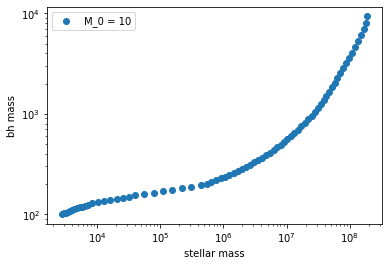

In [12]:

plt.scatter(sm_av, bh_av, label="M_0 = 10")
plt.legend()
plt.xlabel("stellar mass")
plt.ylabel("bh mass")
plt.yscale("log")
plt.xscale("log")

# Read in the heavy seeds

In [15]:
BRANCH_PER_TREE = 1
tree_ids, all_branches = get_all_branches()

working on tree 0
working on tree 1
working on tree 2
working on tree 3
working on tree 4
working on tree 5
working on tree 6
working on tree 7
working on tree 8
working on tree 9
working on tree 10
working on tree 11
working on tree 12
working on tree 13
working on tree 14
working on tree 15
working on tree 16
working on tree 17
working on tree 18
working on tree 19
working on tree 20
working on tree 21
working on tree 22
working on tree 23
working on tree 24
working on tree 25
working on tree 26
working on tree 27
working on tree 28
working on tree 29
working on tree 30
working on tree 31
working on tree 32
working on tree 33
working on tree 34
working on tree 35
working on tree 36
working on tree 37
working on tree 38
working on tree 39


In [17]:
len(all_branches)
all_branches[0]

,z,time,mass,t_vir,stellar_mass,j_mean,j_ratio,j_lw,ind,desc
0,29.511991,98.379330,6.291240e+06,10334.421453,3.292646e+03,38.49,4.330184,57.730651,56042.0,56041.0
1,28.915041,101.338606,7.083300e+06,10965.754652,3.436251e+03,39.55,1.649905,9.541395,56041.0,56040.0
2,28.329814,104.386660,9.302080e+06,12893.027656,3.790433e+03,39.55,1.058050,2.841396,56040.0,56039.0
3,27.756290,107.524956,1.029560e+07,13525.706417,3.956744e+03,39.55,1.687348,5.934708,56039.0,56036.0
4,27.193634,110.759647,1.128220e+07,14095.268662,4.172424e+03,39.55,1.089308,2.403009,56036.0,56033.0
...,...,...,...,...,...,...,...,...,...,...
79,5.406068,1021.194738,6.031720e+10,980700.350873,1.268800e+08,30.27,0.629279,19.047721,4933.0,2841.0
80,5.280736,1051.822150,6.262370e+10,985963.376943,1.307251e+08,30.27,0.911880,27.601798,2841.0,1391.0
81,5.157863,1083.360836,6.416120e+10,982529.425341,1.317676e+08,30.27,1.194532,36.157410,1391.0,432.0
82,5.037371,1115.845080,6.533410e+10,975110.426777,1.314660e+08,30.27,0.990345,29.976852,432.0,0.0


In [19]:

def grow_heavy_seeds(branches,ft, cap,seed):
    all_trees=[]
    for b in branches: 
        tree = b[b["z"] < 25]
        tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
        all_trees.append(tree)
    return all_trees

all_trees = grow_heavy_seeds(all_branches, 45*5, 0.1, 1e5)

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [28]:
tau, seed = 100,1e5
all_trees = grow_heavy_seeds(all_branches, tau, 0.1, seed)

names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_1.csv',index=False)

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [24]:
df = pd.read_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_1.csv')

In [25]:
df

,z,median_bh_mass,median_stellar_mass
0,24.541479,1.000000e+05,4.335439e+03
1,24.041945,1.022003e+05,4.678094e+03
2,23.551927,1.045168e+05,5.047530e+03
3,23.071444,1.069589e+05,5.453860e+03
4,22.600491,1.095340e+05,5.897925e+03
...,...,...,...
70,5.406068,5.286551e+06,1.626351e+08
71,5.280736,6.057444e+06,1.742856e+08
72,5.157863,6.968917e+06,1.890988e+08
73,5.037371,8.051306e+06,2.073957e+08


In [27]:
np.log10(np.array([low_mh, up_mh]))

array([12.22022022, 12.92792793])

# Doing something similar for Masafusa

"The exact host stellar masses we estimate are log M*/Msun ~ 10.6. So, probably 10^12.5 Msun makes sense."


In [28]:
m_h = np.logspace(7,14, 1000)
z = np.linspace(5,5, len(m_h))
low, up =  10.4, 10.8

m_star = calc_mass(m_h, z)
log_m_star = np.log10(m_star)

args = np.where((log_m_star >= low) & (log_m_star <= up))
low_mh, up_mh = np.min(m_h[args]), np.max(m_h[args])

mf = MassFunction()
dndm = mf.dndm
m = mf.m
args_hm = np.where((m>= low_mh) & (m <= up_mh))

m_filt = m[args_hm]
dndm_filt = dndm[args_hm]

dms = m_filt[1:] - m_filt[:-1]
dn = dndm_filt[:-1]*dms


cumsum = np.cumsum(dn)

N_trees = int(2000)
rans = np.random.uniform(low=np.min(cumsum), high=np.max(cumsum),size=N_trees)
m_h_target =interpolate.interp1d(cumsum, m_filt[:-1], kind='cubic',fill_value='extrapolate')(rans)

In [4]:
# N_trees = int(2000)

N_per_file = 100
working_dir = "trees_for_m"
N_files = int(N_trees/N_per_file)
catalog_base = "catalog_base.txt"
for x in range(N_files):
    number = str(x)
#     with io.open(working_dir+"/"+catalog_base, "r", newline='\n') as fin:
#         with io.open(working_dir+"/catalog"+number+".txt", "w", newline='\n') as fout:
#             for line in fin:
#                 if("mass" not in line):
#                     fout.write((line.replace('N', number)).replace('\r', ''))
#             #print(list(fout))
#             mhs = m_h_target[x*N_per_file:(x+1)*N_per_file]
#             for i in range(len(mhs)):
#                 newline = "{:e}".format(mhs[i])+"   0  " + number + "\n"
#                 fout.write(newline.replace('\r', ''))
#     fin.close()
#     fout.close()
    
#     with io.open(working_dir+"/skx_base", "r", newline='\n') as fin:
#         with io.open(working_dir+"/skx"+number, "w", newline='\n') as fout:
#             for line in fin:
#                 fout.write((line.replace('NUMBER', number)).replace('\r', ''))

    with io.open(working_dir+"/skx_find_base", "r", newline='\n') as fin:
        with io.open(working_dir+"/skx_find"+number, "w", newline='\n') as fout:
            for line in fin:
                fout.write((line.replace('NUMBER', number)).replace('\r', ''))




    fin.close()
    fout.close()
    
# with io.open(working_dir+"/submit_jobs_find.sh", "w", newline='\n') as fout:
#     fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
#     for x in range(N_files):
        
#         fout.write(("sbatch skx_find"+str(x)+"\n\n").replace('\r', ''))
#     fout.close()

# with io.open(working_dir+"/submit_jobs.sh", "w", newline='\n') as fout:
#     fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
#     for x in range(N_files):
        
#         fout.write(("sbatch skx"+str(x)+"\n\n").replace('\r', ''))
#     fout.close()

# with io.open(working_dir+"/submit_jobs.sh", "w", newline='\n') as fout:
#     fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
#     for x in range(N_files):
        
#         fout.write(("sbatch skx"+str(x)+"\n\n").replace('\r', ''))
#     fout.close()

In [32]:
np.max(np.log10(m_h_target))

12.90985234428261